In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

In [66]:
input_size = 1 # no of past data to to consider
num_steps = 1 # consecutive input elements are grouped into one training input
num_layers=1  # no of layers
keep_prob=0.8 # keep probability of each node
batch_size = 64 # batch size of input data
learning_rate = 0.001 # learning rate
max_epoch = 200 # no of epochs
test_train_split = 0.8 #test train split

In [67]:
prices_dataset =  pd.read_csv('prices.csv', header=0)

In [68]:
prices_dataset.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [69]:
google = prices_dataset[prices_dataset['symbol']=='GOOGL']

In [70]:
google.head()

,date,symbol,open,close,low,high,volume
440,2010-01-04,GOOGL,626.950006,626.750011,624.240011,629.510005,3908400.0
908,2010-01-05,GOOGL,627.180001,623.990017,621.540016,627.839984,6003300.0
1376,2010-01-06,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0
1844,2010-01-07,GOOGL,609.400008,594.100015,592.649990,609.999993,12815700.0
2312,2010-01-08,GOOGL,592.000005,602.020005,589.110015,603.250036,9439100.0


In [71]:
google_stock_prices = google.close.values.astype('float32')

In [72]:
google_stock_prices.shape

(1762,)

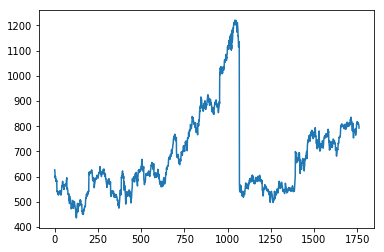

In [73]:
plt.plot(google_stock_prices)

In [74]:
## preprocessing of data, scale data into a scale of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
google_stock_prices = scaler.fit_transform(google_stock_prices)

/home/pankaj/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/pankaj/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


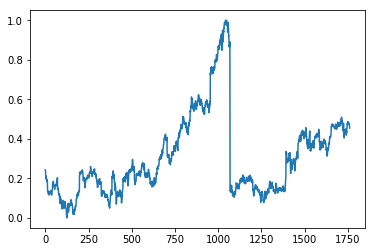

In [75]:
plt.plot(google_stock_prices)

In [76]:
def create_dataset(seq, input_size, num_steps):
    # group according to input size
    seq = [np.array(seq[i * input_size: (i + 1) * input_size]) for i in range(len(seq) // input_size)]
    
    # Split into groups of `num_steps`
    X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
    y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])
    return X,y

In [77]:
split = round(test_train_split*len(google_stock_prices))
train = google_stock_prices[0:split]
test = google_stock_prices[split:len(google_stock_prices)]
print("split: ",train.shape,test.shape)

split:  (1410,) (352,)


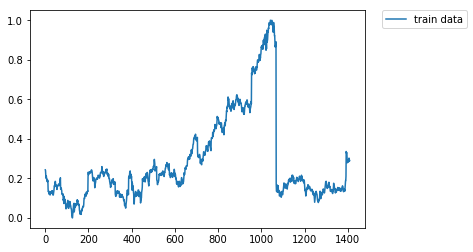

In [78]:
# train data
plt.plot(train, label = 'train data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

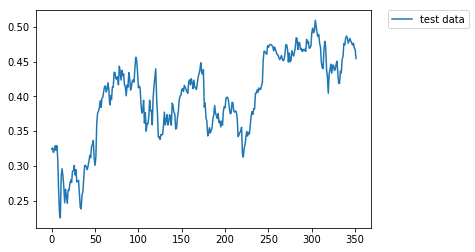

In [79]:
#test data
plt.plot(test, label ='test data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [80]:
## create data test and train
train_x,train_y = create_dataset(train,input_size, num_steps)
test_x,test_y = create_dataset(test,input_size, num_steps)

In [17]:
import tensorflow as tf
tf.reset_default_graph()
lstm_graph = tf.Graph()

In [18]:
with lstm_graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, num_steps, input_size])
    targets = tf.placeholder(tf.float32, [None, input_size])
    #learning_rate = tf.placeholder(tf.float32, None)
    
    def create_one_cell():
        return tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True)
        if keep_prob < 1.0:
            return tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        
    ##stack the cells into multiple layers if needed. MultiRNNCell helps connect sequentially multiple 
    ##simple cells to compose one cell.    
    if num_layers > 1:
        cell = tf.contrib.rnn.MultiRNNCell([create_one_cell() for _ in range(num_layers)], state_is_tuple=True)
    else:
        cell = create_one_cell()
        
    ## tf.nn.dynamic_rnn constructs a recurrent neural network specified by cell (RNNCell). 
    ## It returns a pair of (model outpus, state), where the outputs val is of size (batch_size, num_steps, 
    ## lstm_size) by default. The state refers to the current state of the LSTM cell, not consumed here.    
    val, _ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    
    # Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
    # After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
    val = tf.transpose(val, [1, 0, 2])
    # last.get_shape() = (batch_size, lstm_size)
    last = tf.gather(val, int(val.get_shape()[0]) - 1, name="last_lstm_output")
    
    # Define weights and biases between the hidden and output layers.
    weight = tf.Variable(tf.truncated_normal([lstm_size, input_size]))
    bias = tf.Variable(tf.constant(0.1, shape=[input_size]))
    prediction = tf.matmul(last, weight) + bias
    
    ## define cost function and minimize it
    loss = tf.reduce_mean(tf.square(prediction - targets))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    minimize = optimizer.minimize(loss)
    

/home/pankaj/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [81]:
with tf.Session(graph=lstm_graph) as sess:
    tf.global_variables_initializer().run()
    
    for epoch_step in range(max_epoch):
        avg_cost = 0.
        total_batch = int(len(train_x)/batch_size)
        
        for i in range(total_batch):
            batch_X = train_x[(i*batch_size):((i*batch_size)+batch_size)]
            batch_y = train_y[(i*batch_size):((i*batch_size)+batch_size)]
            train_loss, _ = sess.run([loss, minimize], feed_dict = {inputs: batch_X, targets: batch_y})
            avg_cost += train_loss / total_batch
            
        if (epoch_step) % 1 == 0:
            print("Epoch:", '%04d' % (epoch_step+1), "cost= ",(avg_cost))
    
    prd_value = sess.run(prediction, feed_dict = {inputs: test_x})    

Epoch: 0001 cost=  0.0285426050197
Epoch: 0002 cost=  0.02952412881
Epoch: 0003 cost=  0.00872400696178
Epoch: 0004 cost=  0.00438060905303
Epoch: 0005 cost=  0.0016640174667
Epoch: 0006 cost=  0.000835870464388
Epoch: 0007 cost=  0.000593226512799
Epoch: 0008 cost=  0.000558742265474
Epoch: 0009 cost=  0.000555214285255
Epoch: 0010 cost=  0.00055617891088
Epoch: 0011 cost=  0.000557411697876
Epoch: 0012 cost=  0.000558397487277
Epoch: 0013 cost=  0.000559235810215
Epoch: 0014 cost=  0.000560139055531
Epoch: 0015 cost=  0.000561164540572
Epoch: 0016 cost=  0.000562266054079
Epoch: 0017 cost=  0.000563412983452
Epoch: 0018 cost=  0.000564625100444
Epoch: 0019 cost=  0.000565934554205
Epoch: 0020 cost=  0.000567355773951
Epoch: 0021 cost=  0.000568890797281
Epoch: 0022 cost=  0.000570548229999
Epoch: 0023 cost=  0.00057234827314
Epoch: 0024 cost=  0.000574313392876
Epoch: 0025 cost=  0.000576465116451
Epoch: 0026 cost=  0.000578822816764
Epoch: 0027 cost=  0.000581411735766
Epoch: 0028 c

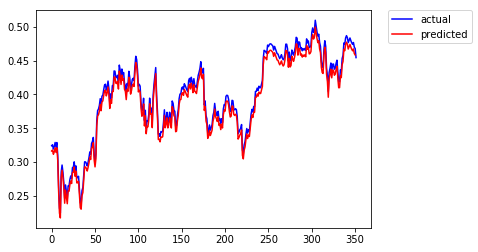

In [82]:
plt.plot(test,'b', label = 'actual')
plt.plot(prd_value,'r', label = 'predicted')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)